In [1]:
#general definitions and imports
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import logging
logging.Logger.disabled=True

import os
import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging( logging_level='CRITICAL')

import numpy as np
import matplotlib.pyplot as plt

import ipytest
ipytest.autoconfig()
from pytest import approx

from pathlib import Path

from PySpice.Unit import *
from PySpice.Spice.Parser import SpiceParser
from PySpice.Spice.Netlist import SubCircuitFactory
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Spice.Netlist import Circuit
from PySpice.Probe.Plot import plot
from PySpice.Math import *

import schemdraw
import schemdraw.elements as elm
from schemdraw import dsp
from schemdraw import logic

## setup spice library path
directory_path = Path(os.path.abspath('')).resolve().parent.parent
spice_libraries_path = directory_path.joinpath("lib", "spice")
spice_library = SpiceLibrary(spice_libraries_path)
## set the project directory as directory_path
directory_path = Path(os.path.abspath('')).resolve()

# construction

the function depends on the patching and settings of the potentiometers. an attenuverter is used in different modules like the  Serge VCS, Maths and also in the polivoks filter. while this module can be used as a simple mixer you can also adjust cv signals. such a signal can be simply attenuated or inverted. when feeding in a positive singal slope (for example from an adsr). the signal will be turned to a neagative dc singal. if the inpout signal is ac coupled the signal will be inverted. the function is the setting on the potentiometer of the channel. when the potentiometer is at center position. the output signal is attenuated to zero. no output singal is present. when turning to the right. the signal will be stronger until the output signal is equal to the input signal. when turning the potentiomenter to the left, the output signal will be phase shifted by 180°. when you turn the potentiometer to full left the output signal will be the inverted input signal. all the inputs are mixed to the output signal; unless you connect the output of a channel. then this output does not accure on the mixed signal.
the attenuverter is build around a differential amplifier with an opamp. 

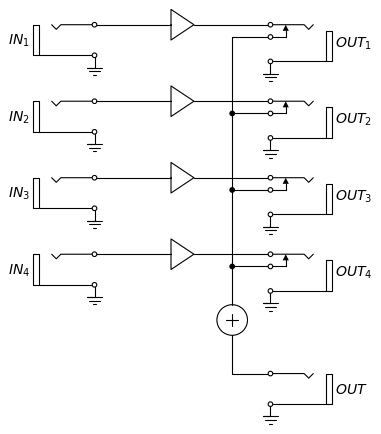

In [5]:
d = schemdraw.Drawing(unit=2.5, inches_per_unit=0.5, lw=1.1)

JI4 = d.add(elm.AudioJack(xy=[0, d.unit], lftlabel='$IN_4$'))
d.add(elm.Ground("right", xy=JI4.sleeve))
d.add(elm.Line( "right", l=d.unit, at=JI4.tip))
D4 = d.add(dsp.Amp())
d.add(elm.Line( "right", l=d.unit))
JO4 = d.add(elm.AudioJack("left", switch=True, flip=True, anchor='tip', rgtlabel='$OUT_4$'))
d.add(elm.Ground("right", xy=JO4.sleeve))

JI3 = d.add(elm.AudioJack(xy=[0, 2*d.unit], lftlabel='$IN_3$'))
d.add(elm.Ground("right", xy=JI3.sleeve))
d.add(elm.Line( "right", l=d.unit, at=JI3.tip))
D3 = d.add(dsp.Amp())
d.add(elm.Line( "right", l=d.unit))
JO3 = d.add(elm.AudioJack("left", switch=True, flip=True, anchor='tip', rgtlabel='$OUT_3$'))
d.add(elm.Ground("right", xy=JO3.sleeve))

JI2 = d.add(elm.AudioJack(xy=[0, 3*d.unit], lftlabel='$IN_2$'))
d.add(elm.Ground("right", xy=JI2.sleeve))
d.add(elm.Line( "right", l=d.unit, at=JI2.tip))
D2 = d.add(dsp.Amp())
d.add(elm.Line( "right", l=d.unit))
JO2 = d.add(elm.AudioJack("left", switch=True, flip=True, anchor='tip', rgtlabel='$OUT_2$'))
d.add(elm.Ground("right", xy=JO2.sleeve))

JI1 = d.add(elm.AudioJack(xy=[0, 4*d.unit], lftlabel='$IN_1$'))
d.add(elm.Ground("right", xy=JI1.sleeve))
d.add(elm.Line( "right", l=d.unit, at=JI1.tip))
D1 = d.add(dsp.Amp())
d.add(elm.Line( "right", l=d.unit))
JO1 = d.add(elm.AudioJack("left", switch=True, flip=True, anchor='tip', rgtlabel='$OUT_1$'))
d.add(elm.Ground("right", xy=JO1.sleeve))

d.add(elm.Line("left", l=d.unit/2, xy=JO1.tipswitch))
d.add(elm.Line("down"))

d.add(elm.Line("left", l=d.unit/2, xy=JO2.tipswitch))
d.add(elm.Dot())
d.add(elm.Line("down"))

d.add(elm.Line("left", l=d.unit/2, xy=JO3.tipswitch))
d.add(elm.Dot())
d.add(elm.Line("down"))

d.add(elm.Line("left", l=d.unit/2, xy=JO4.tipswitch))
d.add(elm.Dot())
d.add(elm.Line("down", l=d.unit/2))
S = d.add(dsp.Sum())  

d.add(elm.Line( "down", xy=S.E, l=d.unit/2))
d.add(elm.Line( "right", l=d.unit/2))
JO = d.add(elm.AudioJack("left", anchor="tip", flip=True, rgtlabel='$OUT$'))
d.add(elm.Ground("right", xy=JO.sleeve))

d.draw()


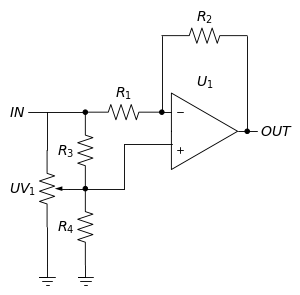

In [6]:
d = schemdraw.Drawing(unit=2.5, inches_per_unit=0.5, lw=0.9)

O = d.add(elm.Opamp( label='$U_1$'))

d.add(elm.Line( "left", xy=O.in1, l=d.unit/8))
R1 = d.add(elm.Resistor( "left", label='$R_1$'))
d.add(logic.Dot())    
R2 = d.add(elm.Resistor( "down", label='$R_3$'))
d.add(elm.Resistor( "down", label='$R_4$'))
d.add(elm.Ground)

L1 = d.add(elm.Line('left', l=d.unit/2, xy=R1.end))
d.add(elm.Line('down', l=d.unit/2))
RV = d.add(elm.Potentiometer('down', toplabel='$UV_1$'))
d.add(elm.Line('down', l=d.unit/2))
d.add(elm.Ground)

d.add(elm.Line('left', l=d.unit/4, xy=L1.end, lftlabel='$IN$'))

d.add(elm.Line('right', tox=R2.end, xy=RV.tap))
d.add(logic.Dot())

d.add(elm.Line('right', l=d.unit/2, xy=R2.end))
d.add(elm.Line('up', l=d.unit*0.58))
d.add(elm.Line('right', l=d.unit*0.63))

d.add(logic.Dot(xy=R1.start))
d.add(elm.Line('up', l=d.unit))
d.add(elm.Resistor('right', label='$R_2$', tox=O.out+d.unit/8))
d.add(elm.Line('down', toy=O.out))
d.add(logic.Dot())

d.add(elm.Line('right', l=d.unit/4, xy=O.out, rgtlabel='$OUT$'))

d.draw()



$$
\begin{array}{c}
Vout = \Bigl(1 + \frac{R2}{R1}\Bigr) \Bigl(\frac{R4}{R3+R4}\Bigr) * V2 - \Bigl(\frac{R2}{R1}\Bigr) * V1
\end{array}
$$



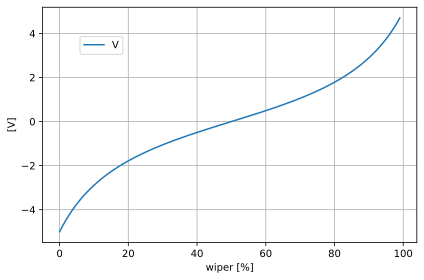

In [7]:
# calcultate the pot sweep
circuit = Circuit('attenuverter')
circuit.include(spice_library['OPA2134'])

circuit.V('1', '+15V', circuit.gnd, 'DC 15')
circuit.V('2', '-15V', circuit.gnd, 'DC -15')
circuit.V('3', 'INPUT', circuit.gnd, 'DC 5 AC 5 SIN(0 5V 1k)')

rv1 = circuit.R('RV1', 'INPUT', 'RV1out', 100@u_kΩ)
rv2 = circuit.R('RV2', 'RV1out', circuit.gnd, 100@u_kΩ)
circuit.R(3, 'INPUT', 'RV1out', 47@u_kΩ)
circuit.R(4, 'RV1out', circuit.gnd, 47@u_kΩ)

circuit.R(1, 'INPUT', 'op_neg', 100@u_kΩ)
circuit.R(2, 'op_neg', 'OUT', 100@u_kΩ)

circuit.X('op', 'OPA2134', 'RV1out', 'op_neg', '+15V', '-15V', 'OUT')

attenuverter_results = []
for s in np.arange( 1, 0, -0.01 ):
    rv1.resistance = s * 100@u_kOhm
    rv2.resistance = 100@u_kOhm - (s * 100@u_kOhm)
    simulator = circuit.simulator(temperature=25, nominal_temperature=25)
    analysis = simulator.operating_point()
    attenuverter_results.append(float(analysis['OUT']))

figure, ax = plt.subplots()
ax.plot(attenuverter_results)  # input
ax.legend(('Vout [V]'), loc=(.1, .8))
ax.grid()
ax.set_xlabel('wiper [%]')
ax.set_ylabel('[V]')

plt.tight_layout()
plt.show()

1.E-11the circuit of the attenuverter is based on the opamp dfferential amplifer. the two resistors at the non-inverting inputs are replaced with a potentiometer. the potentiometer is configured as a voltage divider and replace R3 and R4 from the differential amplifier. when the position of the potentiometer is adjusted, the output voltage will change or invert. at the center position  the output is zero volrs. the response to the potentiometer is linear. we can make it an centered s-curve by adding two parallel resistors (R5,R6) to the potentiometer [[2]](https://sound-au.com/pots.htm).

a simulation with the resistance at RV 1 changed from 0-100%. first run is the linear result. the second run is done with the resistors R5 and R6 added. This results in a s curve. the shape of the curve can be changed with the values of the resistors.

The summing amplifier is not stable and self oscilates. This is most likely because of the long summing bus. This oscilaltion can be removed with a capacitor in parallel to the resistor. The cutoff frequency is as follow:

In [12]:
F = 1 / (2*np.pi*100000*4.7E-11)
print(' Frequency: %f Hz' % F)

 Frequency: 33862.753849 Hz


{% include bom.html content="summe-main-bom" %}
{% include callouts.html %}
{% include reports.html%}

# calibration

there is no calibration needed. but the potentiomenter knobs have to be aliged to center position.


# usage

the input jacks are wired to 5 volts when nothing is connected.

all channels are mixed to the out jack. when something is connected to the channel out, this channel is removed from the overall mix.

_mixer_
* connect the different channels from audio or cv sources to the in jacks.
* connect the out jack to something
* turn the pots clockwise to adjust the volume.

_attenuverter_
* connect all or a single channel. 
* when you turn the pot knob counter clockwise the signal is inverted.




# references

- [Care and Feeding of Spring Reverb Tanks](https://sound-au.com/articles/reverb.htm) Rod Elliott (ESP)
- [Beginners' Guide to Potentiometers](https://sound-au.com/pots.htm)  
